# Cliffwalk gridworld with SARSA, Expected SARSA, and Q-learning

In [1]:
import tabrl

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from copy import deepcopy
from itertools import product
from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14

In [3]:
n_rows = 4
n_cols = 12

In [4]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    # [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
# name_movements = ["right", "left", "down", "up", "nothing"]

map_movements = {n: move for n, move in enumerate(name_movements)}

In [5]:
start_ix = 36
end_ix = 47
reward_goal =  100
G = tabrl.gridworld.CliffGridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

In [6]:
n_steps = 10_000
epsilon = 0.1
alpha = 0.5
gamma = 1.0

seed = 314
hist_sarsa, Q_sarsa = tabrl.agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    tabrl.agents.sarsa_update,
    seed=seed
)

hist_qlearn, Q_qlearn = tabrl.agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    tabrl.agents.qlearning_update,
    seed=seed
)

hist_expected_sarsa, Q_expected_sarsa = tabrl.agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    tabrl.agents.expected_sarsa_update
)

hist = {
    "sarsa": deepcopy(hist_sarsa),
    "q": deepcopy(hist_qlearn),
    "expected_sarsa": deepcopy(hist_expected_sarsa)
}

In [7]:
hist["sarsa"]["reward"][-500:].mean()

np.float64(1.23)

In [8]:
hist["q"]["reward"][-500:].mean()

np.float64(4.256)

In [9]:
hist["expected_sarsa"]["reward"][-500:].mean()

np.float64(4.252)

In [11]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

In [12]:
def plot_agent_run(
    ax, hist_agent, run, gridworld, reward_goal,
    c_line="black", c_arrow="crimson", show_step=False
):
    ix_goal = np.where(hist_agent["reward"] == reward_goal)[0]
    pos_hist = np.c_[hist_agent["ix"] % gridworld.n_cols, hist_agent["ix"] // gridworld.n_cols]
    iinit = ix_goal[run] + 1
    iend = ix_goal[run + 1] + 1
    
    subhist_action = hist_agent["action"][iinit:iend]
    subhist_action = [name_movements[a] for a in subhist_action]
    subhist_action = [markers[action] for action in subhist_action]
    
    subhist_pos = pos_hist[iinit:iend]
    
    ax.plot(*subhist_pos.T, c=c_line, linestyle="--")
    
    for i, ((x,y), m) in enumerate(zip(subhist_pos, subhist_action)):
        ax.scatter(x, y, marker=m, zorder=3, s=50, c=c_arrow)
        if show_step:
            ax.text(x, y, i, verticalalignment="bottom", horizontalalignment="left")


def plot_gridworld_board(ax, gridworld):
    xticks = np.arange(gridworld.n_cols)
    yticks = np.arange(gridworld.n_rows)
    ax.set(
        xticks=xticks + 0.5,
        yticks=yticks + 0.5,
        xticklabels="",
        yticklabels="",
    )
    ax.set_xticks(xticks, labels=xticks, minor=True)
    ax.set_yticks(yticks, labels=yticks, minor=True)
    
    ax.set_ylim(-0.5, gridworld.n_rows - 0.5)
    ax.set_xlim(-0.5, gridworld.n_cols - 0.5)
    ax.invert_yaxis()
    
    for i, (r, c) in enumerate(product(range(gridworld.n_rows), range(gridworld.n_cols))):
        ax.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)
    
    ax.grid(alpha=0.3)

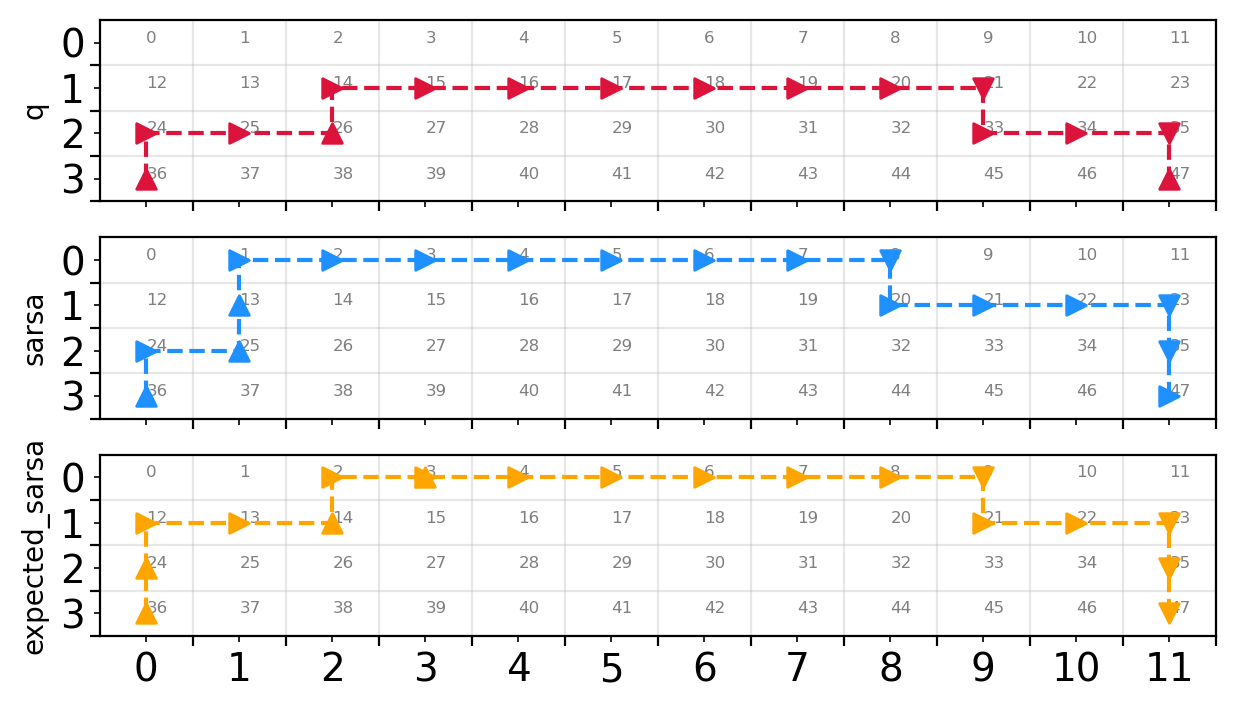

In [13]:
# fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))

fig, axs = plt.subplots(3, 1, figsize=(n_cols * 0.6, n_rows), sharex=True)

agents = ["q", "sarsa", "expected_sarsa"]
colors = ["crimson", "dodgerblue", "orange"]
run = -4
for ax, agent_name, color in zip(axs.ravel(), agents, colors):
    plot_gridworld_board(ax, G)
    ax.set_ylabel(agent_name, fontsize=10)
    plot_agent_run(ax, hist[agent_name], run, G, reward_goal, c_line=color, c_arrow=color)
    
# plot_agent_run(ax, hist["sarsa"], -3, G, reward_goal, c_line="dodgerblue", c_arrow="dodgerblue")
# plot_agent_run(ax, hist["expected_sarsa"], -3, G, reward_goal, c_line="orange", c_arrow="orange")

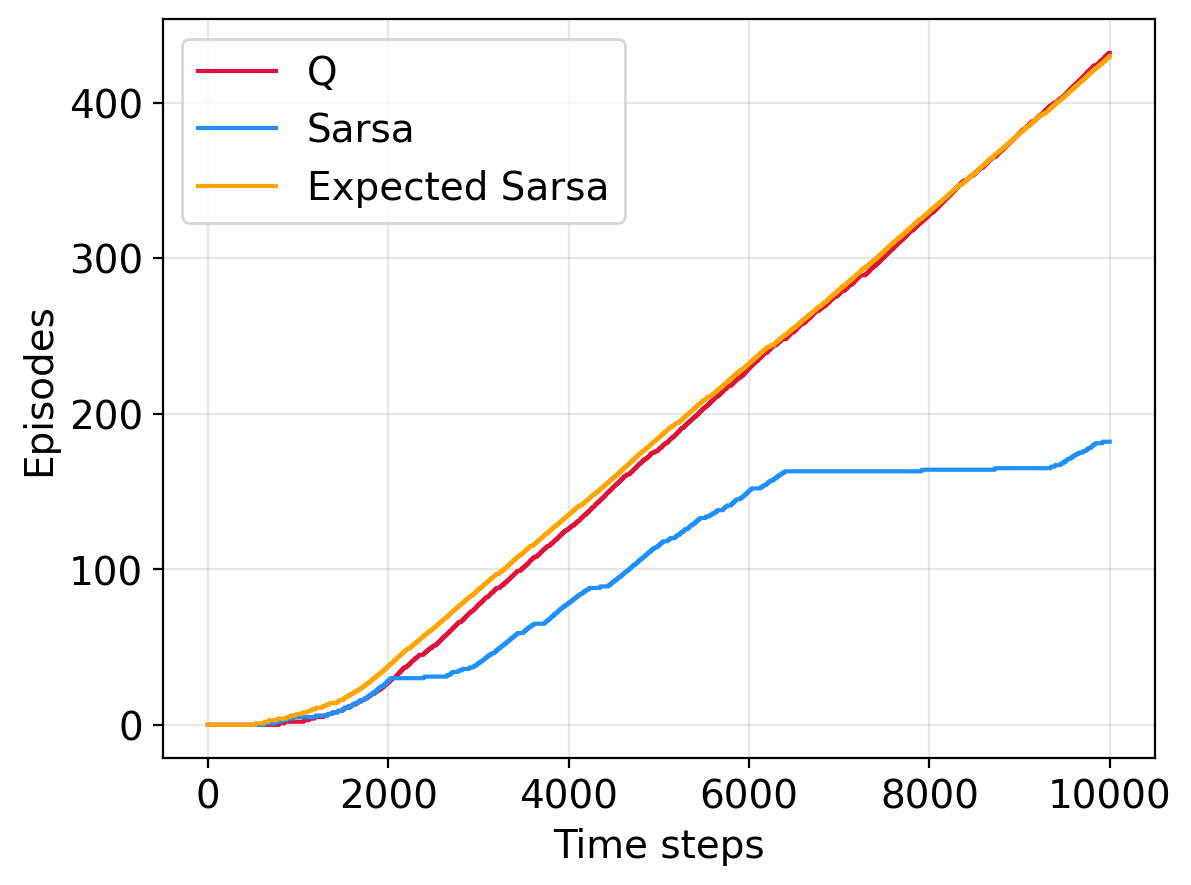

In [14]:
plt.plot((hist["q"]["reward"] == reward_goal).cumsum(), c="crimson", label="Q")
plt.plot((hist["sarsa"]["reward"] == reward_goal).cumsum(), c="dodgerblue", label="Sarsa")
plt.plot((hist["expected_sarsa"]["reward"] == reward_goal).cumsum(), c="orange", label="Expected Sarsa")

plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

In [15]:
np.array([markers[map_movements[a]] for a in Q_qlearn.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['>', 'v', 'v', '>', '>', 'v', 'v', '>', 'v', 'v', '>', 'v'],
       ['>', 'v', '>', '>', '>', '>', '>', '>', '>', 'v', 'v', 'v'],
       ['>', '>', '^', '>', '>', '^', '<', '>', '>', '>', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '^']],
      dtype='<U1')

In [16]:
np.array([markers[map_movements[a]] for a in Q_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['>', '>', '>', '>', '>', '>', '>', '>', 'v', '<', '>', 'v'],
       ['>', 'v', '>', '^', '>', '>', '^', '>', '>', '>', '>', 'v'],
       ['^', '^', '^', '^', '^', '<', '<', '^', '<', '^', '^', '^'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>']],
      dtype='<U1')

In [17]:
np.array([markers[map_movements[a]] for a in Q_expected_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['v', '>', '>', '>', '>', '>', '>', '>', '>', 'v', 'v', 'v'],
       ['>', '>', '^', '>', '^', '>', '>', '>', '>', '>', '>', 'v'],
       ['^', '^', '^', '^', '<', '^', '^', '>', '^', '>', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v']],
      dtype='<U1')

## Multiple runs

In [18]:
def sims_agent(update_fn, alpha, n_episodes, n_simulations):
    simulations_return = tabrl.agents.simulations_run_agent_return(
        start_ix, G, n_actions, n_episodes, epsilon, alpha, gamma, movements,
        update_fn, seed=seed,
        n_simulations=n_simulations
    )
    return simulations_return

In [19]:
%%time
alpha = 0.5
n_simulations = 1000
n_episodes = 100

simulations_q = sims_agent(tabrl.agents.qlearning_update, alpha, n_episodes, n_simulations)
simulations_sarsa = sims_agent(tabrl.agents.sarsa_update, alpha, n_episodes, n_simulations)
simulations_expected_sarsa = sims_agent(tabrl.agents.expected_sarsa_update, alpha, n_episodes, n_simulations)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 1min 4s, sys: 237 ms, total: 1min 5s
Wall time: 9.56 s


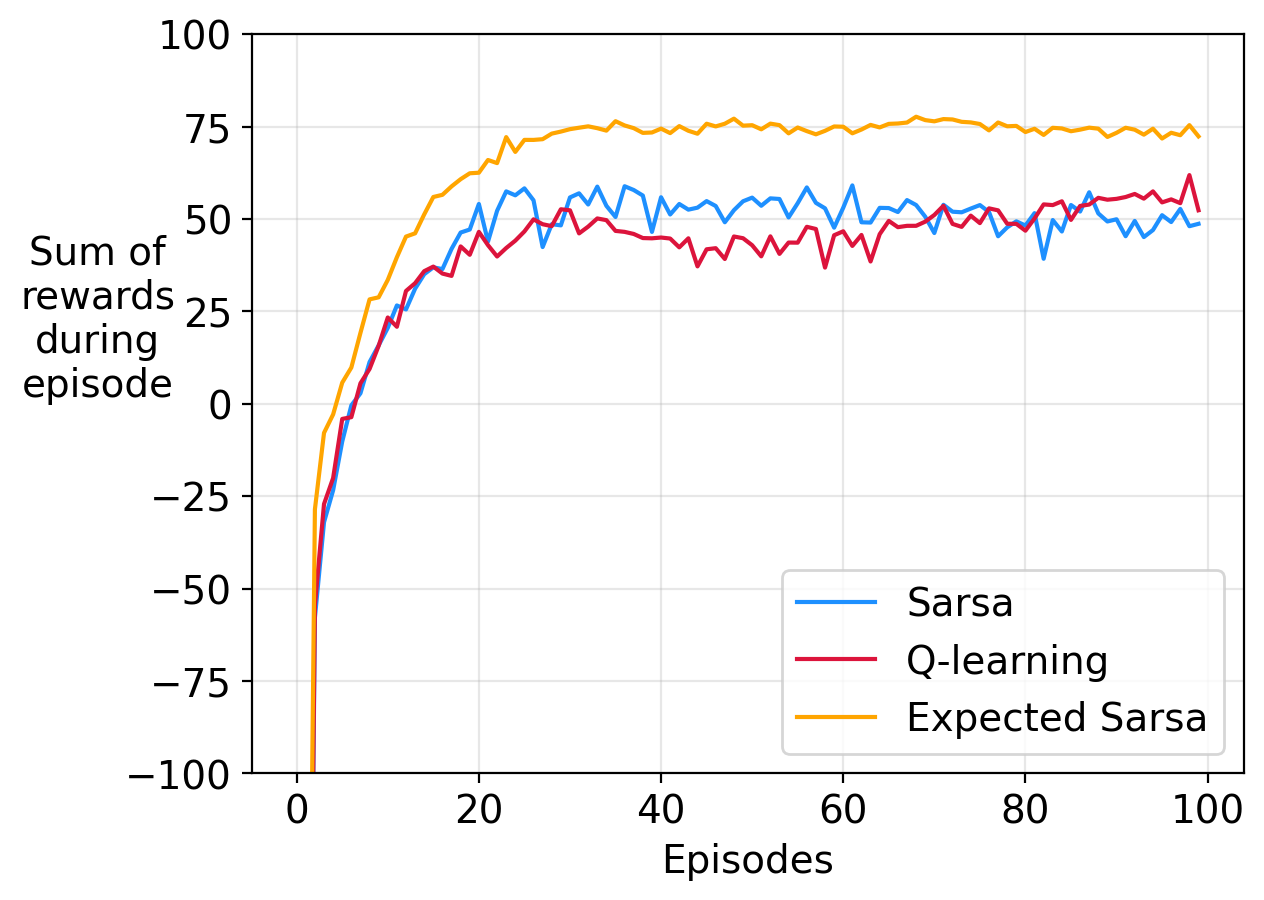

In [20]:
plt.plot(simulations_sarsa.mean(axis=0), label="Sarsa", c="dodgerblue")
plt.plot(simulations_q.mean(axis=0), label="Q-learning", c="crimson")
plt.plot(simulations_expected_sarsa.mean(axis=0), label="Expected Sarsa", c="orange")

plt.legend()
# plt.ylim(bottom=-500, top=-100)
plt.ylim(bottom=-100, top=100)
plt.xlabel("Episodes")
plt.ylabel("Sum of\nrewards\nduring\nepisode", rotation=0, labelpad=10)
plt.grid(alpha=0.3)

### Figure 6.3 — Asymptotic and interim performance of TD

In [21]:
cmap = {
    "Sarsa": "dodgerblue",
    "Q-learning": "crimson",
    "Expected-Sarsa": "orange"
}

In [22]:
alpha_values = np.arange(0.1, 1.1, 0.1)

# Asymptotic configuration
n_episodes = 500
n_sims = 500

# Interim configuration
# n_episodes = 10
# n_sims = 1000

# episodes and number of simulations
configurations = {
    "interim": [10, 1000],
    "asymptotic": [500, 100]
}

configuration_performance = {}
for conf_type in configurations:
    n_episodes, n_simulations = configurations[conf_type]
    
    n_alpha_vals = len(alpha_values)
    performance = {
        "Sarsa": np.zeros((n_alpha_vals, n_sims)),
        "Q-learning": np.zeros((n_alpha_vals, n_sims)),
        "Expected-Sarsa": np.zeros((n_alpha_vals, n_sims)),
    }
    
    for i, alpha in tqdm(enumerate(alpha_values), total=n_alpha_vals, desc=conf_type):
        simulations_q = sims_agent(tabrl.agents.qlearning_update, alpha, n_episodes, n_sims)
        simulations_sarsa = sims_agent(tabrl.agents.sarsa_update, alpha, n_episodes, n_sims)
        simulations_expected_sarsa = sims_agent(tabrl.agents.expected_sarsa_update, alpha, n_episodes, n_sims)
    
        performance["Q-learning"][i] = simulations_q[:, -1]
        performance["Sarsa"][i] = simulations_sarsa[:, -1]
        performance["Expected-Sarsa"][i] = simulations_expected_sarsa[:, -1]

    configuration_performance[conf_type] = performance

asymptotic: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.35s/it]


(-100.0, 97.334)

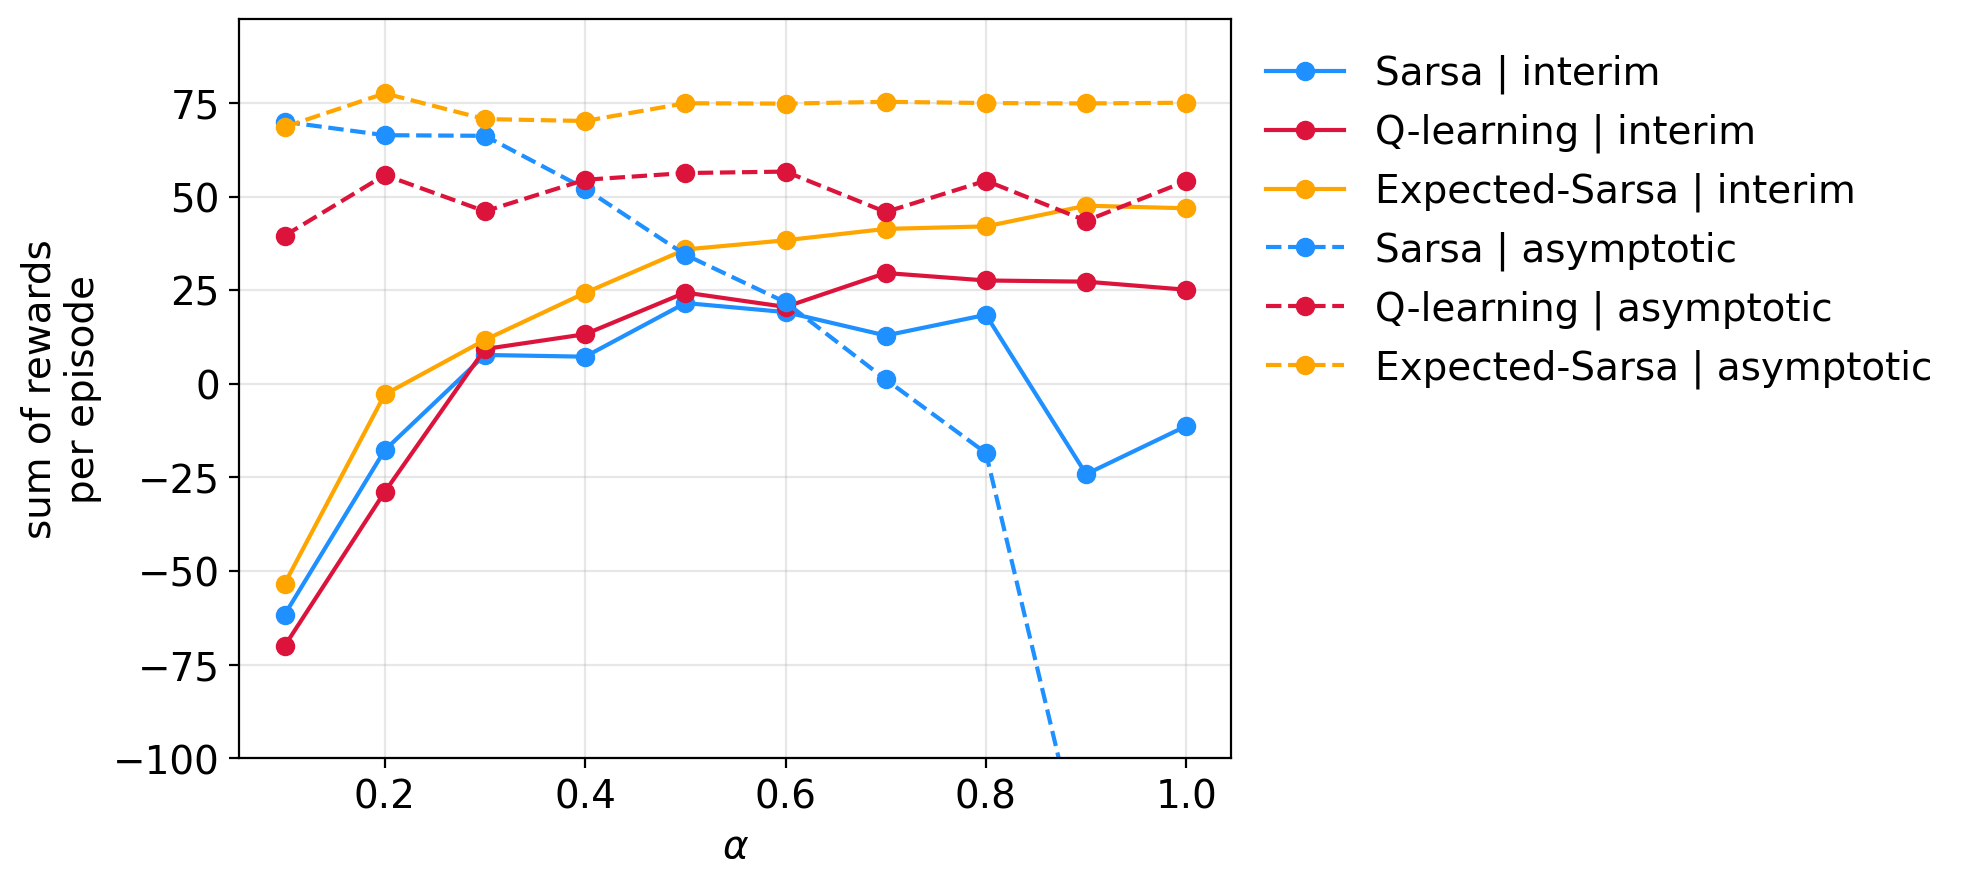

In [23]:
linestyle = ["solid", "dashed"]
for conf_type, ls in zip(configuration_performance, linestyle):
    performance = configuration_performance[conf_type]
    for name_agent in performance:
        color = cmap[name_agent]
        label = f"{name_agent} | {conf_type}"
        plt.plot(
            alpha_values, performance[name_agent].mean(axis=-1), marker="o",
            label=label, color=color, linestyle=ls
        )
plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel(r"$\alpha$")
plt.ylabel("sum of rewards\nper episode")
plt.grid(alpha=0.3)
plt.ylim(bottom=-100)